In [1]:
from google.colab import drive
drive.mount('/content/GoogleDrive/')


Mounted at /content/GoogleDrive/


# **Thư viện**

In [2]:
!pip install -q datasets==2.18
!pip install -q demoji
!pip install -q underthesea
!pip install -q emoji
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 560.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 3.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
import regex as re
import string
import emoji
import underthesea
from nltk import flatten
import pandas as pd
import demoji

In [4]:
import keras
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [5]:
# import os
# if os.environ['COLAB_TPU_ADDR']:
#     cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
#     tf.config.experimental_connect_to_cluster(cluster_resolver)
#     tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
#     strategy = tf.distribute.TPUStrategy(cluster_resolver)
#     print('Using TPU')
#     print("All devices: ", tf.config.list_logical_devices('TPU'))
# elif tf.test.is_gpu_available():
#     strategy = tf.distribute.MirroredStrategy()
#     print('Using GPU')
# else: raise ValueError('Running on CPU is not recommended.')

In [6]:
demoji.download_codes()

tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

<ipython-input-6-588d142025e6>:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


Retrieving speedtest.net configuration...
Testing from Google Cloud (34.121.199.98)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by Binary.Net (Omaha, NE) [12.44 km]: 26.138 ms
Testing download speed................................................................................
Download: 1373.05 Mbit/s
Testing upload speed......................................................................................................
Upload: 473.05 Mbit/s


# **Load dữ liệu**

In [7]:
TRAIN_PATH = "/content/GoogleDrive/MyDrive/Sentiment-Analysis/Train.csv"
VAL_PATH = "/content/GoogleDrive/MyDrive/Sentiment-Analysis/Val.csv"
TEST_PATH = "/content/GoogleDrive/MyDrive/Sentiment-Analysis/Test.csv"

In [8]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment', 'CAMERA', 'SCREEN', 'GENERAL', 'STORAGE', 'PERFORMANCE', 'SERACC', 'BATTERY', 'PRICE', 'DESIGN', 'FEATURES'],
        num_rows: 7786
    })
    val: Dataset({
        features: ['comment', 'CAMERA', 'SCREEN', 'GENERAL', 'STORAGE', 'PERFORMANCE', 'SERACC', 'BATTERY', 'PRICE', 'DESIGN', 'FEATURES'],
        num_rows: 2224
    })
    test: Dataset({
        features: ['comment', 'CAMERA', 'SCREEN', 'GENERAL', 'STORAGE', 'PERFORMANCE', 'SERACC', 'BATTERY', 'PRICE', 'DESIGN', 'FEATURES'],
        num_rows: 1112
    })
})

In [9]:
import pandas as pd
df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train.head(3)

,comment,CAMERA,SCREEN,GENERAL,STORAGE,PERFORMANCE,SERACC,BATTERY,PRICE,DESIGN,FEATURES
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,3,0,3,0,0,3,3,3,0,3
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,0,0,3,0,0,0,1,0,0,0
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,0,0,0,0,0,0,0,0,0,1


# **Tiền xử lí text**

In [10]:
# Remove HTML code
def remove_HTML(text):
    return re.sub(r'<[^>]*>', '', text)

# Standardize unicode
def convert_unicode(text):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )


# Standardize accent typing
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]

for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)


def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True


def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)


import regex as re
def standardize_sentence_typing(text):
    words = text.lower().split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([\p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3:
            cw[1] = standardize_word_typing(cw[1])  # Assuming you have a function to standardize word typing
        words[index] = ''.join(cw)
    return ' '.join(words)



# Normalize acronyms
# !wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',

    'sz': 'cỡ', 'size': 'cỡ',
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài',

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực',
    '😔': 'tiêu cực', '😓': 'tiêu cực',
    '⭐': 'star', '*': 'star', '🌟': 'star',
    'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
    'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
    'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
    'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ','bk':'biết',
    'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' tích cực ', 'dthoai':'điện thoại','thegioididong':'thế giới di động', 'đt': 'điện thoại','dt': 'điện thoại',
    ' por ': u' tiêu cực ',' poor ': u' tiêu cực ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ','zin':'tích cực','fb': 'mạng xã hội','lag':'tiêu cực',
    'hazzz': 'tiêu cực','test': 'thử','bit': 'biết', 'ak':'à','noiz':'nói','rats':'rất','j':'gì','diss':'tiêu cực',
    '4 sao': 'tích cực','5 sao': 'tích cực','1 sao': 'tiêu cực', 'phên': 'tích cực','kog': 'không', 'mia': 'mua', 'ja':'giá','way':'quay', 'zay':'vậy'}

def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word.lower() not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word.lower()])
    return demoji.replace(text, "")

# Remove unnecessary characters
def remove_unnecessary_characters(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

def preprocess(text, word_tokenize = None):
    text = text.strip()
    #tokens = sent.split()
    #for token in tokens:
        #for t in token:
            #if t.isnumeric() or t.isdigit():
                #tokens.remove(token)
                #break
    text = remove_HTML(text)
    text = convert_unicode(text)
    # text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)

    tokens = text.split()
    text= underthesea.word_tokenize(" ".join(tokens), format="text")
    text = remove_unnecessary_characters(text)
    # return text.lower()
    return text

# text = preprocess("một ngày buồn hay vui =))). Ủa? Tôi sinh nhật ngày 1/10 cơ mà. Một Ngày.⚽")
# print(text)

In [11]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0]
            elif sentiment == 1: one_hot = [0, 1, 0, 0]
            elif sentiment == 2: one_hot = [0, 0, 1, 0]
            elif sentiment == 3: one_hot = [0, 0, 0, 1]
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [12]:
y_train = make_outputs(df_train)
y_val = make_outputs(df_val)
y_test = make_outputs(df_test)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]

Train outputs: (7786, 10, 4)
Validate outputs: (2224, 10, 4)
Test outputs: (1112, 10, 4)


array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

# **Load PreTrained Tokenization**

In [13]:
from transformers import TFAutoModel, AutoTokenizer

PRETRAINED_MODEL = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

max_input_size = tokenizer.model_max_length
print("Max input sizes:", max_input_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Max input sizes: 256


In [14]:
def tokenize_function(examples):
    clean_texts = [preprocess(comment) for comment in examples['comment']]
    tokenized_inputs = tokenizer(clean_texts, max_length=256, truncation=True, padding='max_length', return_tensors="tf")

    return tokenized_inputs
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/7786 [00:00<?, ? examples/s]

Map:   0%|          | 0/2224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1112 [00:00<?, ? examples/s]

In [15]:
print('input_ids of sentence 1:', tokenized_datasets['train']['input_ids'][1])


input_ids of sentence 1: [0, 18297, 1029, 50, 44, 57524, 4241, 188, 358, 107, 2669, 415, 2179, 50, 4371, 10, 277, 475, 70, 17, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['comment', 'CAMERA', 'SCREEN', 'GENERAL', 'STORAGE', 'PERFORMANCE', 'SERACC', 'BATTERY', 'PRICE', 'DESIGN', 'FEATURES', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7786
    })
    val: Dataset({
        features: ['comment', 'CAMERA', 'SCREEN', 'GENERAL', 'STORAGE', 'PERFORMANCE', 'SERACC', 'BATTERY', 'PRICE', 'DESIGN', 'FEATURES', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2224
    })
    test: Dataset({
        features: ['comment', 'CAMERA', 'SCREEN', 'GENERAL', 'STORAGE', 'PERFORMANCE', 'SERACC', 'BATTERY', 'PRICE', 'DESIGN', 'FEATURES', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1112
    })
})

# **TensorFlow**

In [21]:
MAX_SEQUENCE_LENGTH = 256
MODEL_PATH = '/content/GoogleDrive/MyDrive/Sentiment-Analysis'
BATCH_SIZE = 21

STEPS_PER_EPOCH = len(raw_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(raw_datasets['val']) // BATCH_SIZE
EPOCHS = 5

In [18]:
print(STEPS_PER_EPOCH)
print(VALIDATION_STEPS)

370
105


In [19]:
import tensorflow as tf

def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    features_to_keep = list(features.keys())[:-3]  # Remove the last 3 features
    return tokenized_dataset.remove_columns(features_to_keep).with_format('tensorflow')

def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf.convert_to_tensor(tf_dataset[x]) for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)
    tf_dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
        tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'],  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 40), dtype=tf.uint8, name=None))>

# **Training**

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions
import os
# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.keras'
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    save_weights_only = False,
    save_freq = 10 * STEPS_PER_EPOCH,
    verbose = 1
)

In [ ]:
# # Assuming train_tf_dataset is your TensorFlow dataset
# num_elements_to_access = 1  # For example, to access the first 10 elements

# for batch in train_tf_dataset.take(num_elements_to_access):
#     input_ids_batch = batch[0]['input_ids']
#     # Process the input_ids_batch or perform any necessary operations
#     print(type(input_ids_batch))


In [23]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Layer
from tensorflow.keras.optimizers import AdamW
class CustomLayer(Layer):
    def __init__(self, pretrained_bert, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.pretrained_bert = pretrained_bert

    def call(self, inputs):
        # Call the TensorFlow function with inputs using pretrained_bert
        return self.pretrained_bert(input_ids = inputs['input_ids'], token_type_ids=inputs['token_type_ids'], attention_mask=inputs['attention_mask']).hidden_states

def create_model(pretrained_bert):
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'),
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'),
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask')
    }

    # Define a custom layer to handle TensorFlow function call
    custom_layer = CustomLayer(pretrained_bert)
    hidden_states = custom_layer(inputs)

    # Combine hidden states
    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]),
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)
    print(pooled_output)

    outputs = concatenate([
        Dense(
            units = 4,
            activation = 'softmax',
            name = label.replace('#', '-').replace('&', '_'),
        )(x) for label in df_train.columns[1:]
    ], axis = -1)

    optimizer = AdamW(learning_rate=1e-4, weight_decay=0.004)  # Set your learning rate and weight decay
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
model = create_model(pretrained_bert)

# Training the model
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    validation_steps=VALIDATION_STEPS,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[early_stop_callback],
    verbose=1
)

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
Epoch 1/20
370/370 [==============================] - 489s 1s/step - loss: 0.2046 - val_loss: 0.1421
Epoch 2/20
370/370 [==============================] - 39s 103ms/step - loss: 0.1779 - val_loss: 0.1425


In [24]:
model.save_weights(f'{MODEL_PATH}/v2.weights.h5')

# **Plot**

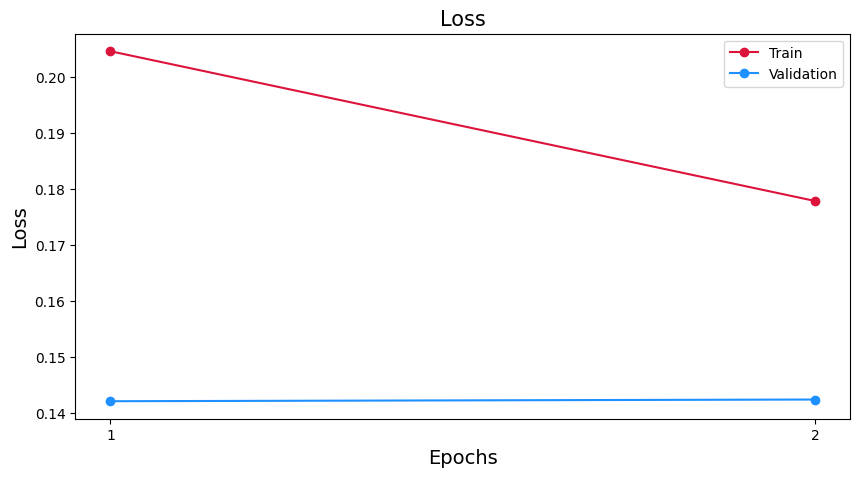

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)  # Assuming the number of epochs is the same for loss and val_loss

fig = plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(epochs, history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')

# Set the ticks on x-axis to represent epochs
plt.xticks(epochs)

fig.savefig(f'{MODEL_PATH}/evaluation_v2.png', bbox_inches='tight')
plt.show()


# **Reload the model**

In [26]:
from tensorflow.train import latest_checkpoint
reloaded_model = create_model(pretrained_bert)
# reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
reloaded_model.load_weights(f'{MODEL_PATH}/v2.weights.h5')
reloaded_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                            

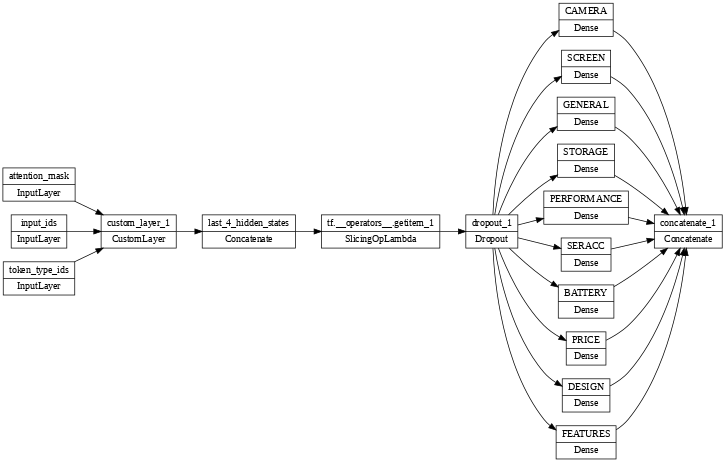

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, to_file=f'{MODEL_PATH}/architecture_v2.png', rankdir='LR', dpi=52, show_layer_names=True)

In [29]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[0, 0, 3, ..., 0, 0, 0],
       [3, 0, 3, ..., 0, 0, 1],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 3, ..., 2, 3, 0],
       [0, 0, 3, ..., 2, 3, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# **Predict on test set**

In [30]:
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category},{sentiment}')

In [31]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)


In [32]:
y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)


53/53 [==============================] - 28s 361ms/step - loss: 0.1378


0.13778483867645264

In [34]:
y_pred

array([[0, 0, 3, ..., 0, 0, 0],
       [2, 0, 3, ..., 0, 0, 1],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 3, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
replacements = {0: None, 3: 'positive', 1: 'negative', 2: 'neutral'}
categories = df_test.columns[1:]
print(categories)
print('Example:', df_test['comment'][6])
print_acsa_pred(replacements, categories, y_pred[6])

Index(['CAMERA', 'SCREEN', 'GENERAL', 'STORAGE', 'PERFORMANCE', 'SERACC',
       'BATTERY', 'PRICE', 'DESIGN', 'FEATURES'],
      dtype='object')
Example: Tôi hiện đang dùng Sam sung S20 Plus (đổi từ Samsung S7 edge khi Hoàng Hà mobile phối hợp Samsung đổi máy cũ lên mới). Qua gần 2 tháng dùng ss20+, gặp vấn đề 3 lần bị treo đơ máy, ảnh chụp khá đẹp nhưng khi đưa ảnh chụp vào lưu trữ khá chậm và ko hơn gì con s7egd cũ của tôi là bao.
=> CAMERA,negative
=> PERFORMANCE,negative
=> SERACC,negative


In [45]:
from tensorflow.data import Dataset

example_input = preprocess(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}

pred = predict(reloaded_model, Dataset.from_tensor_slices(features))
print_acsa_pred(replacements, categories, pred[0])

Enter your sentence: cam như cc
=> CAMERA,negative


# **Aspect Detection**

In [46]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [47]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.9494    0.9541    0.9517      7804
     BATTERY     0.9667    0.9782    0.9724       504
      CAMERA     0.9153    0.9493    0.9320       296
      DESIGN     0.8914    0.8342    0.8619       187
    FEATURES     0.8737    0.8714    0.8725       381
     GENERAL     0.8707    0.8897    0.8801       689
 PERFORMANCE     0.8503    0.9175    0.8826       582
       PRICE     0.9498    0.8254    0.8832       252
      SCREEN     0.7965    0.7438    0.7692       121
      SERACC     0.8797    0.7310    0.7985       290
     STORAGE     1.0000    0.0000    0.0000        14

    accuracy                         0.9321     11120
   macro avg     0.9039    0.7904    0.8004     11120
weighted avg     0.9322    0.9321    0.9311     11120



# **Polarity Classification**

In [48]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))

In [49]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))


              precision    recall  f1-score   support

        None     0.9494    0.9541    0.9517      7804
    positive     0.6863    0.7488    0.7162      1011
    negative     0.6432    0.3360    0.4414       381
     neutral     0.8349    0.8571    0.8459      1924

    accuracy                         0.8975     11120
   macro avg     0.7785    0.7240    0.7388     11120
weighted avg     0.8952    0.8975    0.8945     11120



# **Aspect + Polarity**


In [50]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

In [51]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))


                      precision    recall  f1-score   support

        BATTERY,None     0.9817    0.9720    0.9769       608
    BATTERY,negative     0.7764    0.8333    0.8039       150
     BATTERY,neutral     0.4444    0.1569    0.2319        51
    BATTERY,positive     0.8550    0.9340    0.8927       303
         CAMERA,None     0.9814    0.9681    0.9747       816
     CAMERA,negative     0.6545    0.8182    0.7273        88
      CAMERA,neutral     0.0000    0.0000    0.0000        36
     CAMERA,positive     0.7551    0.8605    0.8043       172
         DESIGN,None     0.9669    0.9795    0.9731       925
     DESIGN,negative     0.6207    0.4500    0.5217        40
      DESIGN,neutral     1.0000    0.0000    0.0000        12
     DESIGN,positive     0.8288    0.8963    0.8612       135
       FEATURES,None     0.9331    0.9343    0.9337       731
   FEATURES,negative     0.7173    0.8712    0.7868       233
    FEATURES,neutral     1.0000    0.0000    0.0000        33
   FEAT

# **Summary**

In [52]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [54]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)


,precision,recall,f1-score,accuracy
Aspect Detection,0.903948,0.790427,0.800388,0.932104
Polarity Detection,0.778461,0.723979,0.738791,0.897482
Aspect + Polarity,0.802810,0.593065,0.591879,0.897482
